In [1]:
import os
from pathlib import Path
import torch
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

from shadowing import (
    RelativeMSE, Foveal, PathShadowing, PredictionContext, 
    realized_variance, ArrayType
)

def _torch(x: ArrayType) -> torch.Tensor:
    """ Convert x to a torch float tensor. """
    if isinstance(x, torch.Tensor):
        return x
    return torch.tensor(x, dtype=torch.float32)

ILLUSTRATION_PATH = Path(os.getcwd()) / 'illustration'

save = False
def save_figure(path, dpi=None):
    if not path.parents[0].is_dir():
        path.parents[0].mkdir(parents=True)
    if save:
        plt.savefig(path, dpi=300 if dpi is None else dpi, bbox_inches='tight')

In [2]:
# PathDistance
distance = RelativeMSE()

x = torch.randn(8,34)
y = torch.randn(128,512,34)

ds1, idces1 = distance.forward_topk(x, y, k=32, n_splits=32)
ds2, idces2 = distance.forward_topk(x, y, k=64, n_splits=64)

assert torch.equal(ds1, ds2[:,:ds1.shape[1]])
assert torch.equal(idces1, idces2[:,:idces1.shape[1],:])

In [3]:
# shadowing correctly select paths
x_context = torch.randn(8, 1, 126)
x_dataset = torch.randn(32, 1, 4096)
embedding = Foveal(alpha=1.15, beta=0.9, max_context=126)
distance = RelativeMSE()
obj = PathShadowing(embedding, distance, x_dataset, context=PredictionContext(horizon=252))
distances, paths, _ = obj.shadow(x_context, n_splits=1, k=1024, cuda=False)

# re-compute the distance
paths = _torch(paths)
paths = obj.context.select_in_context(paths)
paths = embedding(paths.view(-1, *paths.shape[2:]))
paths = paths.view(*distances.shape, -1)
x_context = _torch(x_context)
x_context = embedding(x_context)
ds_test = distance(x_context, paths)
assert torch.allclose(ds_test, _torch(distances), rtol=1e-2)

In [4]:
# execution time
x_context = torch.randn(1, 1, 126)
x_dataset = torch.randn(131072, 1, 4096)
embedding = Foveal(alpha=1.15, beta=0.9, max_context=126)
distance = RelativeMSE()
obj = PathShadowing(embedding, distance, x_dataset, context=PredictionContext(horizon=252))
to_predict = lambda x: realized_variance(x, Ts=[2,7,252], vol=False)
pred, pred_std = obj.predict(
    x_context, k=10000, to_predict=to_predict, eta=0.1, n_context_splits=1, n_dataset_splits=8, cuda=True
)

100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


# Github README

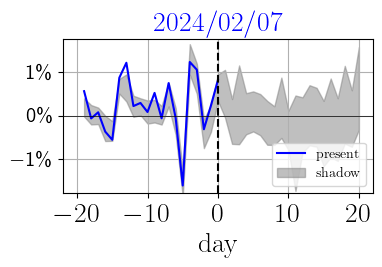

In [5]:
save = False

from scatspectra import SPDaily, TimeSeriesDataset
from shadowing import (
    PathShadowing, Identity, RelativeMSE, PredictionContext, plot_shadow
)

# current past history of SnP
snp = SPDaily()
dlnx_current = snp.dlnx[0,0,-20:]

# generated dataset  # can be generated using the script `generate_dataset.py`
dpath = Path(os.getcwd()) / '_cache' / 'snp_generation_batched'
# dpath = Path("/path/to/your/generated/dataset")
dataset = TimeSeriesDataset(dpath, R=32768)  # dataset of 32768 long trajectories

# shadowing
embedding = Identity(dlnx_current.shape[-1])  # simple embedding
distance = RelativeMSE()  # distance in the embedding space 
obj = PathShadowing(
    embedding=embedding,
    distance=distance,
    dataset=dataset,
    context=PredictionContext(horizon=20),
)
distances, close_paths, _ = obj.shadow(
    dlnx_current,
    k=8192, # get the 1024 closest paths from the generated dataset
    cuda=True
)

# helper function for plotting the shadow of a path 
plot_shadow(dlnx_current, distances[0,:], close_paths[0,:,:,:], eta=0.09, date=snp.dts[-1], color='blue');

save_figure(ILLUSTRATION_PATH / 'shadowing.png')

(3,)


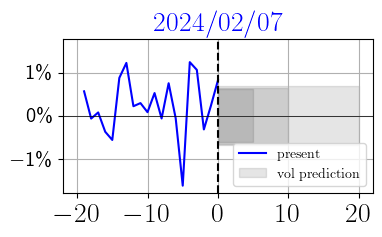

In [6]:
save = False

from shadowing import plot_volatility

Ts = np.array([5,10,20])  # the time scales at which we want to predict the volatility

# the function to apply to each path 
to_predict = lambda x: realized_variance(x, Ts=Ts, vol=False)[:,:,0,:]

# now aggreate predictions on the 1024 closest paths with a weighted average
vols, _ = obj.predict_from_paths(
    distances,
    close_paths,
    to_predict=to_predict,
    proba_name='softmax',
    eta=0.1,
)

# helper function for plotting vol predictions
plot_volatility(dlnx_current, (vols[-1,:] / 252) ** 0.5, Ts, date=snp.dts[-1], color='blue')

save_figure(ILLUSTRATION_PATH / 'vol_prediction.png')

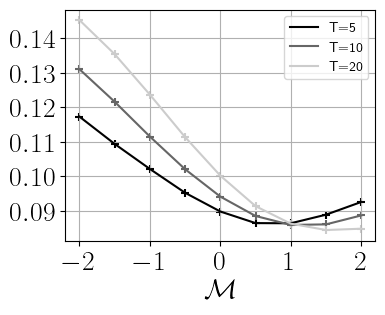

In [7]:
save = False

# compute the smile at this date 
from scatspectra import Softmax, PriceData, compute_smile

# averaging operator in Hedged HMC
ave = Softmax(distances[-1,:], eta=0.9)

# the shadowing paths extending the currently observed past
x = PriceData(dlnx=close_paths[-1,:,0,20:], x_init=100.0).x

# HMC on such shadowing paths
Ms = np.linspace(-2,2,9)
smile_conditional = compute_smile(x, Ts, Ms, ave=ave)

# plotting
_, ax = plt.subplots(1, 1, figsize=(4,3))
smile_conditional.plot(ax=ax, color='black', rescale=True, legend=True)
plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.xlabel(r"$\mathcal{M}$", fontsize=20);

save_figure(ILLUSTRATION_PATH / 'smile.png')